C:\Users\marte\AppData\Local\Temp\ipykernel_8364\2486825089.py:62: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('housing.data', header=None, delim_whitespace=True)


ymin: 2.0 ymax: 4.0


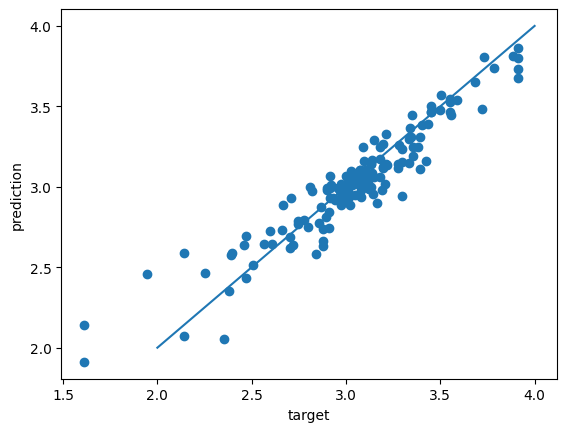

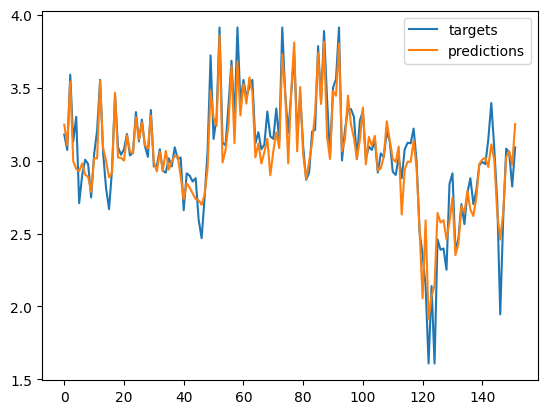

CV single tree: 0.7082625777810646
CV baseline: 0.7334124106491924
CV forest: 0.8454588268453935
test score single tree: 0.6853867620381551
test score baseline: 0.8207262773549386
test score forest: 0.8768939902469755


In [1]:
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range, input

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

NUMERICAL_COLS = [
  'crim', # numerical
  'zn', # numerical
  'nonretail', # numerical
  'nox', # numerical
  'rooms', # numerical
  'age', # numerical
  'dis', # numerical
  'rad', # numerical
  'tax', # numerical
  'ptratio', # numerical
  'b', # numerical
  'lstat', # numerical
]

NO_TRANSFORM = ['river']

# transforms data from dataframe to numerical matrix
# we want to use the scales found in training when transforming the test set
# so only call fit() once
# call transform() for any subsequent data
class DataTransformer:
  def fit(self, df):
    self.scalers = {}
    for col in NUMERICAL_COLS:
      scaler = StandardScaler()
      scaler.fit(df[col].values.reshape(-1, 1))
      self.scalers[col] = scaler

  def transform(self, df):
    N, _ = df.shape
    D = len(NUMERICAL_COLS) + len(NO_TRANSFORM)
    X = np.zeros((N, D))
    i = 0
    for col, scaler in iteritems(self.scalers):
      X[:,i] = scaler.transform(df[col].values.reshape(-1, 1)).flatten()
      i += 1
    for col in NO_TRANSFORM:
      X[:,i] = df[col]
      i += 1
    return X

  def fit_transform(self, df):
    self.fit(df)
    return self.transform(df)


def get_data():
  df = pd.read_csv('housing.data', header=None, delim_whitespace=True)
  df.columns = [
    'crim', # numerical
    'zn', # numerical
    'nonretail', # numerical
    'river', # binary
    'nox', # numerical
    'rooms', # numerical
    'age', # numerical
    'dis', # numerical
    'rad', # numerical
    'tax', # numerical
    'ptratio', # numerical
    'b', # numerical
    'lstat', # numerical
    'medv', # numerical -- this is the target
  ]

  # transform the data
  transformer = DataTransformer()

  # shuffle the data
  N = len(df)
  train_idx = np.random.choice(N, size=int(0.7*N), replace=False)
  test_idx = [i for i in range(N) if i not in train_idx]
  df_train = df.loc[train_idx]
  df_test = df.loc[test_idx]

  Xtrain = transformer.fit_transform(df_train)
  Ytrain = np.log(df_train['medv'].values)
  Xtest = transformer.transform(df_test)
  Ytest = np.log(df_test['medv'].values)
  return Xtrain, Ytrain, Xtest, Ytest


if __name__ == '__main__':
  Xtrain, Ytrain, Xtest, Ytest = get_data()

  model = RandomForestRegressor(n_estimators=100) # try 10, 20, 50, 100, 200
  model.fit(Xtrain, Ytrain)
  predictions = model.predict(Xtest)

  # plot predictions vs targets
  plt.scatter(Ytest, predictions)
  plt.xlabel("target")
  plt.ylabel("prediction")
  ymin = np.round( min( min(Ytest), min(predictions) ) )
  ymax = np.ceil( max( max(Ytest), max(predictions) ) )
  print("ymin:", ymin, "ymax:", ymax)
  r = range(int(ymin), int(ymax) + 1)
  plt.plot(r, r)
  plt.show()

  plt.plot(Ytest, label='targets')
  plt.plot(predictions, label='predictions')
  plt.legend()
  plt.show()

  # do a quick baseline test
  baseline = LinearRegression()
  single_tree = DecisionTreeRegressor()
  print("CV single tree:", cross_val_score(single_tree, Xtrain, Ytrain, cv=5).mean())
  print("CV baseline:", cross_val_score(baseline, Xtrain, Ytrain, cv=5).mean())
  print("CV forest:", cross_val_score(model, Xtrain, Ytrain, cv=5).mean())

  # test score
  single_tree.fit(Xtrain, Ytrain)
  baseline.fit(Xtrain, Ytrain)
  print("test score single tree:", single_tree.score(Xtest, Ytest))
  print("test score baseline:", baseline.score(Xtest, Ytest))
  print("test score forest:", model.score(Xtest, Ytest))

